# Spliting Neurons into Sections



In [1]:
!pip install uv --user
!uv pip install --system navis
!uv pip install --system networkx
!uv pip install --system matplotlib
!uv pip install --system cloud-volume

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 33.8 MB/s eta 0:00:00
Using Python 3.11.11 environment at: /usr
Resolved 47 packages in 297ms
⠙ Preparing packages... (0/16)
⠙ Preparing packages... (0/16)
⠙ Preparing packages... (0/16)
flexcache  ------------------------------     0 B/12.95 KiB
⠙ Preparing packages... (0/16)
flexcache  ------------------------------ 12.95 KiB/12.95 KiB
⠙ Preparing packages... (0/16)
texttable  ------------------------------     0 B/10.52 KiB
flexcache  ------------------------------ 12.95 KiB/12.95 KiB
⠙ Preparing packages... (0/16)
texttable  ------------------------------ 10.52 KiB/10.52 KiB
flexcache  ------------------------------ 12.95 KiB/12.95 KiB
⠙ Preparing packages... (0/16)
texttable  ------------------------------ 10.52 KiB/10.52 KiB
flexcache  ------------------------------ 12.95 KiB/12.95 KiB
fuzzywuzzy ------------------------------ 14.87 KiB/17.84 KiB
⠙ Preparing packages... (0/16)
texttable  ------------------------------ 10.52

In [2]:
import google.colab.auth
google.colab.auth.authenticate_user()

In [3]:
import os
import navis
import networkx as nx
import matplotlib.pyplot as plt
from cloudvolume import CloudVolume

In [4]:
neuron_id = 3896803064
bucket_path = 'h01-release/data/20210601/c3/'

In [5]:
## Download a small example neuron skeletons using CloudVolume.
cv = CloudVolume(f'gs://{bucket_path}', mip=0, cache=False, use_https=True)

skeletons = cv.skeleton.get([neuron_id])
skeleton = skeletons[0] if skeletons else None

# Delete the old swc
if os.path.exists(f'{neuron_id}.swc'):
  os.remove(f'{neuron_id}.swc')

# Save the neuron skeleton to swc
swc_file = f'{neuron_id}.swc'
with open(swc_file, 'w') as f:
    f.write(skeleton.to_swc())
    print(f'Skeleton saved as SWC: {swc_file}')

Decompressing: 100%|██████████| 1/1 [00:00<00:00, 132.68it/s]


Skeleton saved as SWC: 3896803064.swc


In [6]:
# Load the skeleton into a navis.TreeNeuron object for further processing
neuron = navis.read_swc(swc_file)

if type(neuron) != navis.TreeNeuron:
  raise Exception(f'Neuron type is {type(neuron)} and not a navis.TreeNeuron')

In [7]:
# Add the missing unit
print(cv.info['scales'][0]['resolution'])

# sanity check
print(neuron.cable_length)

# Convert to micrometers and millimeters
cable_length_um = neuron.cable_length / 1000
cable_length_mm = neuron.cable_length / 1_000_000

print(f"Cable Length in nm: {neuron.cable_length} nm")
print(f"Cable Length in µm: {cable_length_um} µm")
print(f"Cable Length in mm: {cable_length_mm} mm")

neuron.units = "nm"  # Set correct unit

[8, 8, 33]
15344019.0
Cable Length in nm: 15344019.0 nm
Cable Length in µm: 15344.019 µm
Cable Length in mm: 15.344019 mm


In [8]:
# fix holes and missing connections by healing the neuron
navis.heal_skeleton(neuron, inplace=True)

,
type,navis.TreeNeuron
name,3896803064
n_nodes,50521
n_connectors,None
n_branches,3884
n_leafs,3902
cable_length,15406663.0
soma,None
units,1 nanometer
created_at,2025-02-12 17:39:26.559356


In [9]:
# Compute parent-child relationships
if 'parent_id' not in neuron.nodes:
    print("Adding parent-child relationships...")
    neuron.reconnect(method='spatial')

In [10]:
# Prune the neuron removing small branches and dust
print(f'Nodes after before: {neuron.n_nodes}')
neuron_pruned = navis.prune_twigs(neuron, size="8192 nm", inplace=False, recursive=True)
print(f'Nodes after pruning: {neuron_pruned.n_nodes}')

Nodes after before: 50521
Nodes after pruning: 23663


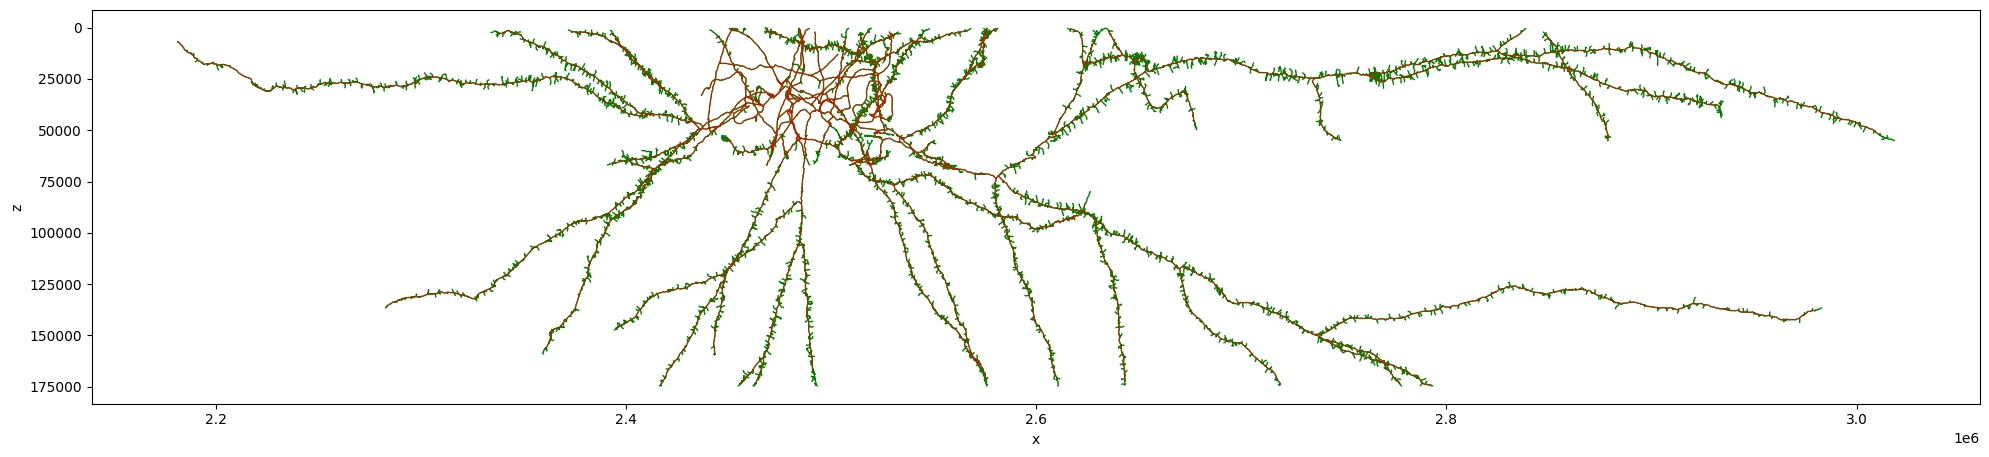

In [11]:
# Plot original neuron in green
fig, ax = neuron.plot2d(color="green", figsize=(20, 20), view=("x", "-z"))

# Plot remaining neuron in red
_, _ = neuron_pruned.plot2d(
    color="red", ax=ax, linewidth=0.5, alpha=1, view=("x", "-z")
)

plt.tight_layout()

In [12]:
# Save pruned neuron
neuron_pruned.to_swc('neuron_pruned_' + swc_file, write_meta=True)

In [13]:
# Reload the pruned neuron to update the indexes
neuron_pruned = navis.read_swc('neuron_pruned_' + swc_file, write_meta=True)

In [14]:
# Convert the graph to networkx
nx_graph = navis.neuron2nx(neuron_pruned)

In [15]:
# Sanity check
print("Nodes - # " + str(len(nx_graph.nodes.keys())) + ":" + str(list(nx_graph.nodes.keys())[:100]))
print("Edges - # " + str(len(nx_graph.edges.keys())) + ":" + str(list(nx_graph.edges.keys())[:100]))

Nodes - # 23663:[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]
Edges - # 23662:[(2, 1), (3, 2), (4, 3), (5, 4), (6, 5), (7, 6), (8, 7), (9, 8), (10, 8), (11, 10), (12, 11), (13, 12), (14, 13), (15, 14), (16, 15), (17, 16), (18, 17), (19, 18), (20, 19), (21, 20), (22, 21), (23, 22), (24, 23), (25, 24), (26, 25), (27, 26), (28, 27), (29, 28), (30, 29), (31, 30), (32, 31), (33, 32), (34, 33), (35, 34), (36, 35), (37, 36), (38, 37), (39, 38), (40, 39), (41, 40), (42, 41), (43, 42), (44, 43), (45, 44), (46, 45), (47, 46), (48, 47), (49, 48), (50, 49), (51, 50), (52, 51), (53, 52), (54, 53), (55, 54), (56, 55), (57, 56), (58, 57), (59, 58), (60, 59), (

In [16]:
# convert the dig to an undirected graph
undirected_graph = nx_graph.to_undirected()

In [17]:
### Compute the center Node

center_node = None
# if no soma is detected calculate the center of the neuron
if neuron_pruned.soma is None:
  # Calculate PageRank for the entire graph
  pagerank = nx.pagerank(undirected_graph)
  center_node = sorted(pagerank.items(), key=lambda x: x[1], reverse=True)[0][0]
else:
  center_node = neuron_pruned.soma.node_id

print(f"Center node: {center_node}")

Center node: 10499


In [18]:
### Generate nodes in a depth-first-search pre-ordering starting at source.
tree_traversal = list(nx.dfs_preorder_nodes(undirected_graph, source=center_node))
print(f"Tree length: {len(tree_traversal)}")
print(f"Tree traversal: {tree_traversal}")

Tree length: 23663
Tree traversal: [10499, 10498, 10497, 10496, 10495, 10493, 10492, 10491, 10490, 10489, 10488, 10487, 10486, 10485, 10484, 10483, 10482, 10481, 10480, 10479, 10478, 10477, 10476, 10475, 10474, 10473, 10472, 10471, 10470, 10469, 10468, 10467, 10466, 10465, 10464, 10463, 10462, 10461, 10460, 10459, 10458, 10457, 10456, 10455, 10454, 10453, 10452, 10451, 10450, 10449, 10448, 10447, 10040, 10039, 10038, 10037, 10036, 10035, 10034, 10033, 10032, 10031, 10030, 10029, 10028, 10027, 10026, 10025, 10024, 10023, 10022, 8545, 8547, 8546, 8544, 8543, 8542, 8541, 8540, 8539, 8538, 8537, 8536, 8535, 8533, 19875, 19876, 19877, 19878, 19879, 19880, 19881, 19882, 19883, 19884, 19885, 19886, 19887, 19888, 19889, 19890, 19891, 19892, 19893, 19894, 19895, 19896, 19897, 19898, 19899, 19900, 19901, 19902, 19903, 19904, 19905, 19906, 19907, 19908, 19909, 19910, 19911, 19912, 19913, 19914, 19915, 19916, 19917, 19918, 19919, 19920, 19921, 19922, 19923, 19924, 19925, 19926, 19927, 19928, 19929

In [68]:
def split_neuron_connected(
    tree_traversal: list[int],
    undirected_graph: nx.Graph,
    section_fraction: int = 4,
) -> list[list[int]]:
    """
    Splits the neuron skeleton into `num_sections` connected segments by identifying meaningful branch points,
    ensuring each section remains connected while approximating equal size. A new segment starts only at
    branch points or when the segment size exceeds `min_segment_size`.

    Args:
        tree_traversal: A list of node indices representing the traversal order of the neuron skeleton.
        undirected_graph: The neuron skeleton graph as an undirected NetworkX graph.
        section_fraction: Used to compute the number of sections as a fraction of number of nodes with degree >= 3.

    Returns:
        A list of `num_sections` largest connected segments.
    """
    # Identify branch points (nodes with degree >= 3)
    branch_points = {node for node, degree in undirected_graph.degree() if degree >= 3}

    # Determine minimum segment size dynamically if not provided
    num_sections = len(branch_points)//section_fraction

    # Walk along the tree traversal and create segments
    segments = []
    current_segment = []
    last_node = None

    for node in tree_traversal:
        is_junction = node in branch_points

        # Add first node to the first section
        if last_node is None:
            current_segment.append(node)
        # Start a new section at a branch point
        elif is_junction:
            if current_segment not in segments:
                segments.append(current_segment)
            current_segment = [node]
        # Add node if directly connected to the last node
        elif undirected_graph.has_edge(last_node, node):
            current_segment.append(node)
        # Add node if it is directly connected to any node in the segment
        elif any(undirected_graph.has_edge(prev_node, node) for prev_node in current_segment):
            current_segment.append(node)
        # If not directly connected, find the smallest parent segment to merge into
        else:
            parent_segment = None
            smallest_parent_segment_size = float('inf')

            for segment in segments:
                if any(undirected_graph.has_edge(seg_node, node) for seg_node in segment):
                    if len(segment) < smallest_parent_segment_size:
                        smallest_parent_segment_size = len(segment)
                        parent_segment = segment

            # If no parent segment found, raise an error
            if parent_segment is None:
                raise ValueError(f"No parent segment found for node {node}. Ensure the neuron skeleton is fully connected.")

            # Move to the parent segment and append the node
            if current_segment not in segments:
                segments.append(current_segment)

            current_segment = parent_segment
            current_segment.append(node)

        last_node = node

    # Append the last segment if it's not already added
    if current_segment not in segments:
        segments.append(current_segment)

    # Ensure each segment is fully connected
    for i, segment in enumerate(segments):
        subgraph = undirected_graph.subgraph(segment)
        if not nx.is_connected(subgraph):
            raise ValueError(f"Segment {i} is not fully connected.")

    return segments, num_sections

In [69]:
def merge_segments_traversal_order(segments: list[list[int]], tree_traversal: list[int], undirected_graph: nx.Graph, num_sections: int) -> list[list[int]]:
    """
    Iteratively merges the smallest segment with the smallest directly connected segment in the depth-first
    traversal until only `num_sections` segments remain.

    Merging rules:
    1. Find all segments that share a direct connection with the current smallest segment.
    2. Of those, check if the first or last node in a candidate segment comes immediately before or after
       the first or last node in the current smallest segment in the tree traversal.
    3. Prefer merging with the smallest segment that meets both conditions.
    4. If no segment meets condition (2), merge with the smallest segment that only meets condition (1).

    Args:
        segments: List of neuron skeleton segments (each a list of node indices).
        tree_traversal: A list of node indices representing the depth-first traversal order.
        undirected_graph: The neuron skeleton graph as an undirected NetworkX graph.
        num_sections: The number of final sections to retain.

    Returns:
        List of `num_sections` connected segments.
    """
    node_position = {node: i for i, node in enumerate(tree_traversal)}

    while len(segments) > num_sections:
        # Step 1: Sort segments by size (ascending, smallest first)
        segments.sort(key=len)

        # Step 2: Pick the smallest segment and remove it from the list
        smallest_segment = segments.pop(0)

        first_node, last_node = smallest_segment[0], smallest_segment[-1]

        # Step 3: Find all directly connected segments
        connected_segments = {
            i: segment for i, segment in enumerate(segments)
            if any(undirected_graph.has_edge(small_node, large_node) for small_node in smallest_segment for large_node in segment)
        }

        # Step 4: Sort connected segments by size (ascending)
        connected_segments = sorted(connected_segments.items(), key=lambda item: len(item[1]))

        merged = False
        for j, connected_seg in connected_segments:
            segment_first, segment_last = connected_seg[0], connected_seg[-1]

            # extend smallest_segment with segment
            if node_position[last_node] == node_position[segment_first] - 1:
                smallest_segment.extend(connected_seg)
                segments[j] = smallest_segment
                merged = True
                break
            # extend segment with smallest_segment
            elif node_position[segment_last] == node_position[first_node] - 1:
                connected_seg.extend(smallest_segment)
                segments[j] = connected_seg
                merged = True
                break

        # Step 5: If no strict adjacency match found, merge with the smallest connected segment
        if not merged:
            smallest_connected_idx, smallest_connected_segment = connected_segments[0]
            smallest_connected_segment.extend(smallest_segment)
            segments[smallest_connected_idx] = smallest_connected_segment

    return segments

In [70]:
segments, num_sections = split_neuron_connected(tree_traversal, undirected_graph, 4)

In [71]:
print(f"Merging {len(segments)} segments into {num_sections} largest segments...")
merged_segments = merge_segments_traversal_order(segments, tree_traversal, undirected_graph, num_sections)
print(f"{len((merged_segments))} merged segments with a joint length of {sum([len(s) for s in merged_segments])}.")

print(merged_segments)

Merging 72 segments into 18 largest segments...
18 merged segments with a joint length of 23663
[[18358, 18359, 18361, 18362, 18363, 18364, 18365, 18366, 18367, 18368, 18369, 18370, 18371, 18372, 18373, 18374, 18375, 18376, 18377, 18378, 18379, 18380, 18381, 18382, 18383, 18384, 18385, 18386, 18387, 18388, 18389, 18390, 18391, 18392, 18393, 18394, 18395, 18396, 18397, 18398, 18399, 18400, 18401, 18402, 18403, 18404, 18405, 18406, 18407, 18408, 18409, 18410, 18411, 18412, 18413, 18414, 18415, 18416, 18417, 18418, 18360, 23462, 23461, 23460, 23459, 23458, 23457, 23456, 23455, 23454, 23453, 23452, 23451, 23450, 23449, 23448, 23447, 23446, 23445, 23444, 23443, 23442, 23441, 23440, 23439, 23438, 23437, 23436, 23435, 23434, 23433, 23432, 23431, 23430, 23429, 23428, 23427, 23426, 23425, 23424, 23423, 23422, 23421, 23420, 23419, 23418, 23417, 23416, 23415, 23414, 23413, 23412, 23411, 23410, 23409, 23408, 23407, 23406, 23405, 23404, 23403, 23402, 23401, 23400, 23399, 23398, 23397, 23396, 23395,